# Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Load the data into a Pandas dataframe

In [2]:
data = pd.read_csv("../data/combined_headlines_new.csv")
data

,date,headlines
0,2020-07-17,Jim Cramer : A better way to invest in the Cov...
1,2020-07-17,Cramer's lightning round : I would own Teradyne
2,2020-07-17,"Cramer's week ahead : Big week for earnings , ..."
3,2020-07-17,IQ Capital CEO Keith Bliss says tech and healt...
4,2020-07-16,Wall Street delivered the 'kind of pullback I'...
...,...,...
53325,2018-03-20,Malaysia says never hired British data firm at...
53326,2018-03-20,Prosecutors search Volkswagen headquarters in ...
53327,2018-03-20,McDonald's sets greenhouse gas reduction targets
53328,2018-03-20,Pratt & Whitney to deliver spare A320neo engin...


In [4]:
data.columns = ['Date', 'Headlines']

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53330 entries, 0 to 53329
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       53330 non-null  object
 1   Headlines  53330 non-null  object
dtypes: object(2)
memory usage: 833.4+ KB


### Convert date column to datetime

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.tz_localize(None)

### Determine date range covered by the dataset

In [7]:
print("Start: ", data["Date"].min().date())
print("End:   ", data["Date"].max().date())

Start:  2017-12-17
End:    2020-07-18


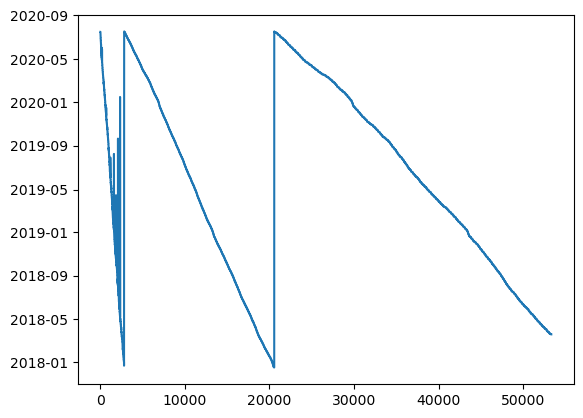

In [8]:
plt.plot(data["Date"])

### Sort data chronologically (will make it easier to verify that financial data is added correctly)

In [9]:
data.sort_values(by='Date', inplace=True)
data = data.reset_index(drop=True)

In [10]:
data

,Date,Headlines
0,2017-12-17,The Guardian view on Ryanair’s model : a union...
1,2017-12-17,Butchers carve out a niche as UK shoppers opt ...
2,2017-12-17,Grogonomics This year has been about companies...
3,2017-12-17,Youngest staff to be given UK workplace pensio...
4,2017-12-17,Peter Preston on press and broadcasting Paul D...
...,...,...
53325,2020-07-18,World Bank calls on creditors to cut poorest n...
53326,2020-07-18,British Airways retires Boeing 747 fleet as Co...
53327,2020-07-18,What will changes to England's lockdown rules ...
53328,2020-07-18,Atol protection to be extended to vouchers on ...


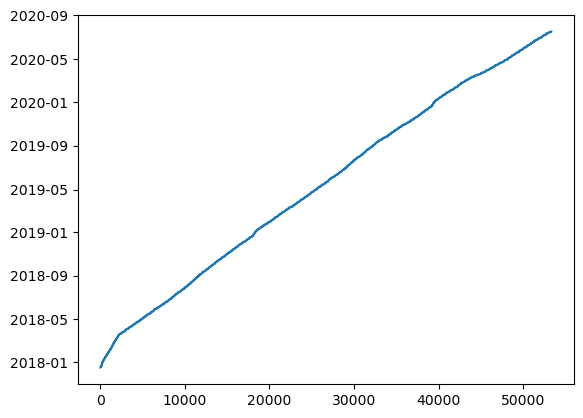

In [11]:
plt.plot(data["Date"])

## Collect financial data from Yahoo Finance

In [12]:
import yfinance as yf

In [13]:
ticker = yf.Ticker("SPY")
start_date = data["Date"].min().date() - pd.Timedelta(days=2) # buffer to account for weekends
end_date = data["Date"].max().date() + pd.Timedelta(days=10)
spy_data = ticker.history(start=start_date, end=end_date)
spy_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2017-12-15 00:00:00-05:00,238.556503,239.985413,238.502584,239.509109,144610300,1.351,0.0,0.0
2017-12-18 00:00:00-05:00,240.937988,241.387332,240.830150,241.027863,83653600,0.000,0.0,0.0
2017-12-19 00:00:00-05:00,241.279496,241.324420,240.030308,240.102219,82382900,0.000,0.0,0.0
2017-12-20 00:00:00-05:00,241.090758,241.144677,239.670844,239.976395,76751500,0.000,0.0,0.0
2017-12-21 00:00:00-05:00,240.614481,241.198650,240.219057,240.470688,67032300,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...
2020-07-21 00:00:00-04:00,307.749419,308.201904,305.383194,306.391907,57292200,0.000,0.0,0.0
2020-07-22 00:00:00-04:00,306.024222,308.456443,305.911101,308.135895,57792900,0.000,0.0,0.0
2020-07-23 00:00:00-04:00,307.768291,308.484764,303.064150,304.459351,75738000,0.000,0.0,0.0


### Reindex to daily frequency, filling missing dates (i.e., when the markets are closed) with previous values

In [14]:
spy_data = spy_data.asfreq("D", method="ffill").reset_index()

In [15]:
spy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype                           
---  ------         --------------  -----                           
 0   Date           956 non-null    datetime64[ns, America/New_York]
 1   Open           956 non-null    float64                         
 2   High           956 non-null    float64                         
 3   Low            956 non-null    float64                         
 4   Close          956 non-null    float64                         
 5   Volume         956 non-null    int64                           
 6   Dividends      956 non-null    float64                         
 7   Stock Splits   956 non-null    float64                         
 8   Capital Gains  956 non-null    float64                         
dtypes: datetime64[ns, America/New_York](1), float64(7), int64(1)
memory usage: 67.3 KB


In [16]:
spy_data["Date"] = spy_data["Date"].dt.tz_localize(None)

### Add columns containing closing values up to 7 days after the current date

In [17]:
for i in range(1, 8):
    spy_data[f"Close+{i}"] = spy_data["Close"].shift(-i)

### Calculate percentage shift in value up to 7 days after the current date

In [18]:
for i in range(1, 8):
    spy_data[f"PercentageD+{i}"] = ( ( spy_data["Close"].shift(-i) - spy_data["Close"] ) / spy_data["Close"] ) * 100

### Add category labels characterizing observed trends (tentative)
    - percentage shift < -0.5% --> -1
    - percentage shift between -0.5% and +0.5% --> 0
    - percentage shift > 0.5% --> 1

In [19]:
for i in range(1, 8):
    spy_data[f"TrendD+{i}"] = spy_data[f"PercentageD+{i}"].apply(
        lambda x: 0 if -0.5 <= x <= 0.5 
        else (-1 if x < -0.5 
        else 1)
    )

In [20]:
spy_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Close+1,...,PercentageD+5,PercentageD+6,PercentageD+7,TrendD+1,TrendD+2,TrendD+3,TrendD+4,TrendD+5,TrendD+6,TrendD+7
0,2017-12-15,238.556503,239.985413,238.502584,239.509109,144610300,1.351,0.0,0.0,239.509109,...,0.195101,0.401479,0.375212,0,0,1,0,0,0,0
1,2017-12-16,238.556503,239.985413,238.502584,239.509109,144610300,1.351,0.0,0.0,239.509109,...,0.401479,0.375212,0.375212,0,1,0,0,0,0,0
2,2017-12-17,238.556503,239.985413,238.502584,239.509109,144610300,1.351,0.0,0.0,241.027863,...,0.375212,0.375212,0.375212,1,0,0,0,0,0,0
3,2017-12-18,240.937988,241.387332,240.830150,241.027863,83653600,0.000,0.0,0.0,240.102219,...,-0.257268,-0.257268,-0.257268,0,0,0,0,0,0,0
4,2017-12-19,241.279496,241.324420,240.030308,240.102219,82382900,0.000,0.0,0.0,239.976395,...,0.127261,0.127261,0.007505,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,2020-07-23,307.768291,308.484764,303.064150,304.459351,75738000,0.000,0.0,0.0,302.498474,...,NaN,NaN,NaN,-1,-1,-1,0,1,1,1
952,2020-07-24,302.564471,303.544874,300.961844,302.498474,73766600,0.000,0.0,0.0,302.498474,...,NaN,NaN,NaN,0,0,1,1,1,1,1
953,2020-07-25,302.564471,303.544874,300.961844,302.498474,73766600,0.000,0.0,0.0,302.498474,...,NaN,NaN,NaN,0,1,1,1,1,1,1
954,2020-07-26,302.564471,303.544874,300.961844,302.498474,73766600,0.000,0.0,0.0,304.704407,...,NaN,NaN,NaN,1,1,1,1,1,1,1


### Merge financial data into original dataframe

In [22]:
data = data.merge(spy_data[["Date", "Close", "Close+1", "Close+2", "Close+3", "Close+4", "Close+5", "Close+6", "Close+7", 
                     "PercentageD+1", "PercentageD+2", "PercentageD+3", "PercentageD+4", "PercentageD+5", "PercentageD+6", "PercentageD+7",
                     "TrendD+1", "TrendD+2", "TrendD+3", "TrendD+4", "TrendD+5", "TrendD+6", "TrendD+7"]], on='Date', how='left')